In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lisatools.sensitivity import *
from lisatools.utils.constants import lisaLT
import sys
sys.path.append('../utility_files/')
from psd_utils import write_psd_file, load_psd_from_file
from sig_processing import waveform, zero_pad, inner_prod


/Users/ollie.burke/Documents/Work/Code/Gaps_EMRIs/toy_problem/../utility_files/sig_processing.py:50: SyntaxWarning: invalid escape sequence '\d'
  It takes in a value of the amplitude $a$, frequency $f$ and frequency derivative $\dot{f}


In [191]:
# Generate waveform
T_obs = np.pi * 1e7
T_obs_year = T_obs/(365*24*60*60)  # Convert seconds to years
dt = 5

sim_t = np.arange(0, T_obs, dt)

A = 1e-22
f_0 = 1e-3
dotf_0 = 1e-10


true_params = [A, f_0, dotf_0] 
h = waveform(true_params, sim_t)
h_zp = zero_pad(h)

N_t_full = len(h_zp)

h_fft  = np.fft.rfft(h_zp)

Using cpu backend for PSD interpolation
PSD range [4.70181046e-45 4.70181046e-45] [4.71787376e-36 4.71787376e-36]


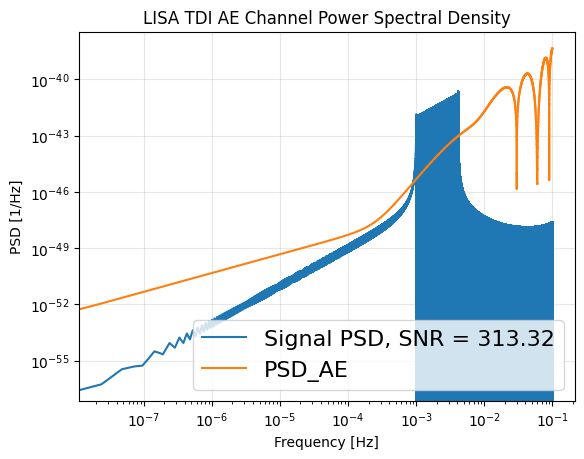

SNR of the source is  313.3184997992232


In [195]:
import os
import matplotlib

matplotlib.rcParams['agg.path.chunksize'] = 10000

PSD_filename = "tdi2_AE_w_background.npy"

kwargs_PSD = {"stochastic_params": [T_obs_year*lisaLT]} # We include the background

write_PSD = write_psd_file(model='scirdv1', channels='AE', 
                           tdi2=True, include_foreground=True, 
                           filename = os.getcwd() + "/" + PSD_filename, **kwargs_PSD)

PSD_AE_interp = load_psd_from_file(os.getcwd() + "/" + PSD_filename, xp=np)

freq = np.fft.rfftfreq(N_t_full, dt)
psd_A = PSD_AE_interp(freq)[0]

SNR2 = inner_prod(h_fft, h_fft, N_t_full, dt, psd_A)

plt.loglog(freq, (freq*h_fft)**2, label='Signal PSD, SNR = {:.2f}'.format(np.sqrt(SNR2)))
plt.loglog(freq,freq*psd_A, label = 'PSD_AE')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
plt.legend(fontsize = 16)
plt.grid(True, alpha=0.3)
plt.title('LISA TDI AE Channel Power Spectral Density')
plt.show()

print("SNR of the source is ", np.sqrt(SNR2))


In [340]:
sim_t/60/60/24/365

array([0.00000000e+00, 1.58548960e-07, 3.17097920e-07, ...,
       9.96192130e-01, 9.96192288e-01, 9.96192447e-01], shape=(6283186,))

Usable data
Duty cyle is = 89.92999729754936 %


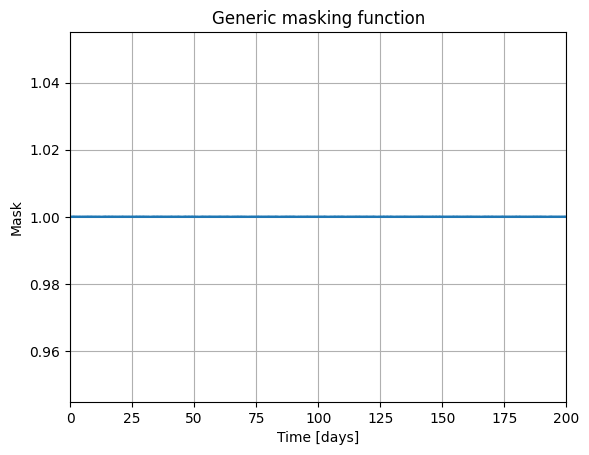

In [ ]:
from lisa_gap import GapMaskGenerator

planseed = 2618240388
unplanseed = 3387490715

# Build dictionary of gap definitions, planned and unplanned. We must 
# supply both of these, even if the rates are zero and durations are zero. 
# We can cope with arbitrary number of gaps.
gap_definitions = {
    "planned": {
        "antenna repointing": {"rate_per_year": 260, "duration_hr": 3.3}, # Fine
        "PAAM": {"rate_per_year": 1095, "duration_hr": 0.028}, # Fine
        #"Aliens": {"rate_per_year": 6, "duration_hr": 30*24}
    },
    "unplanned": {
        "platform safe mode": {"rate_per_year": 3, "duration_hr": 60},
    }
}

# Initialise the class with simulation properties and whether or not to treat gaps with
# nans or not. 
gap_mask_gen = GapMaskGenerator(sim_t, 
                                dt, 
                                gap_definitions, 
                                treat_as_nan = True)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
# num_zeros = np.sum(full_mask == 0)/len(full_mask)
full_mask = gap_mask_gen.generate_mask(include_unplanned=False, include_planned=True)
num_nans = np.sum(np.isnan(full_mask))/len(full_mask)
print("Usable data")
print(f"Duty cyle is = {100*(1-num_nans)} %")


plt.plot(sim_t/60/60/24,full_mask)
plt.xlim([0,200])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Generic masking function')
plt.grid()


In [349]:
variance_noise_f = (N_t_full * psd_A/(4*dt))

def noise_gen(seed = 1, mask = None):
    np.random.seed(seed)
    noise_f = (np.random.normal(0, np.sqrt(variance_noise_f)) +
                1j * np.random.normal(0, np.sqrt(variance_noise_f)))

    variance_noise_f_DC = (N_t_full * psd_A[0]/(2*dt)) 
    variance_noise_f_nyq = (N_t_full * psd_A[-1]/(2*dt)) 

    noise_f_DC = np.random.normal(0,np.sqrt(variance_noise_f_DC), 1)
    noise_f_nyq = np.random.normal(0,np.sqrt(variance_noise_f_nyq), 1)

    noise_f[0] = noise_f_DC
    noise_f[-1] = noise_f_nyq

    if mask is None:
        return noise_f
    else:
        noise_t = np.fft.irfft(noise_f)
        noise_t_masked = noise_t * mask
        noise_f_masked = np.fft.rfft(noise_t_masked)
        return noise_f_masked


/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq


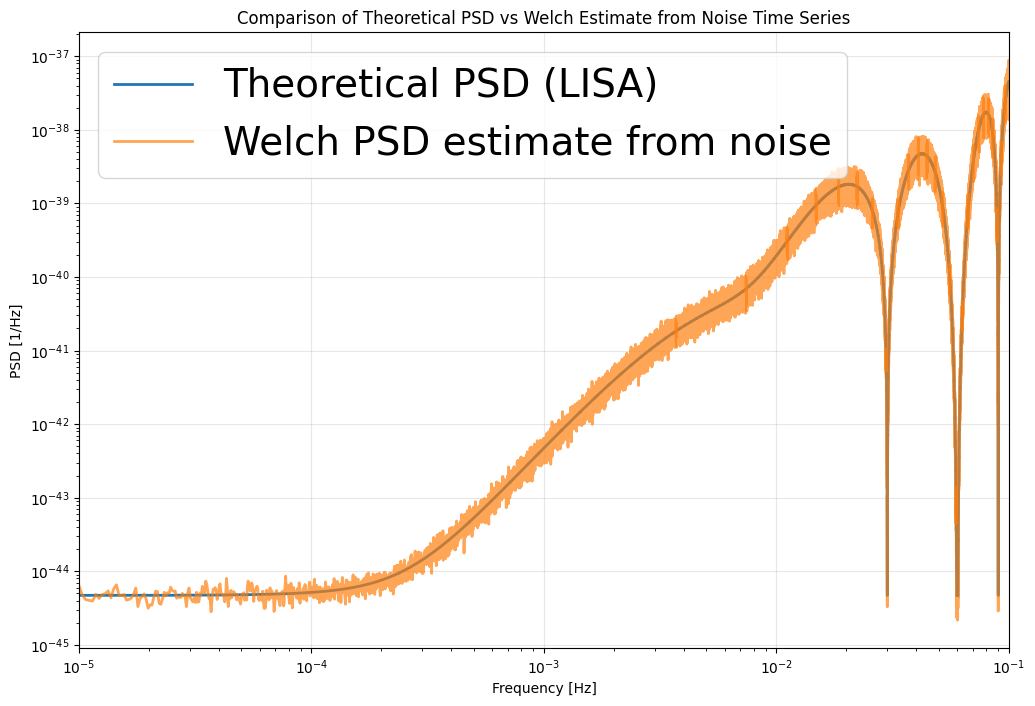

Frequency range (theoretical): 2.38e-08 - 1.00e-01 Hz
Frequency range (Welch): 3.81e-07 - 1.00e-01 Hz
Mean ratio (Welch/Theoretical) in overlap region: 1.00


In [350]:
from scipy import signal

# Compute Welch's PSD of the noise time series

noise_f = noise_gen(seed = 1, mask = None)
noise_t = np.fft.irfft(noise_f)

freq_welch, psd_welch = signal.welch(noise_t, fs=1/dt, nperseg=len(noise_t)//16)

# Plot comparison between theoretical PSD and Welch estimate
plt.figure(figsize=(12, 8))
plt.loglog(freq, psd_A, label='Theoretical PSD (LISA)', linewidth=2)
plt.loglog(freq_welch, psd_welch, label='Welch PSD estimate from noise', alpha=0.7, linewidth=2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
plt.legend(fontsize=28)
plt.grid(True, alpha=0.3)
plt.title('Comparison of Theoretical PSD vs Welch Estimate from Noise Time Series')
plt.xlim([1e-5, 1e-1])
plt.show()

# Print some statistics
print(f"Frequency range (theoretical): {freq[1]:.2e} - {freq[-1]:.2e} Hz")
print(f"Frequency range (Welch): {freq_welch[1]:.2e} - {freq_welch[-1]:.2e} Hz")
print(f"Mean ratio (Welch/Theoretical) in overlap region: {np.mean(psd_welch[1:]/np.interp(freq_welch[1:], freq, psd_A)):.2f}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.1916404667755035e-25
(9.892188578872375e-20+0j)


/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq


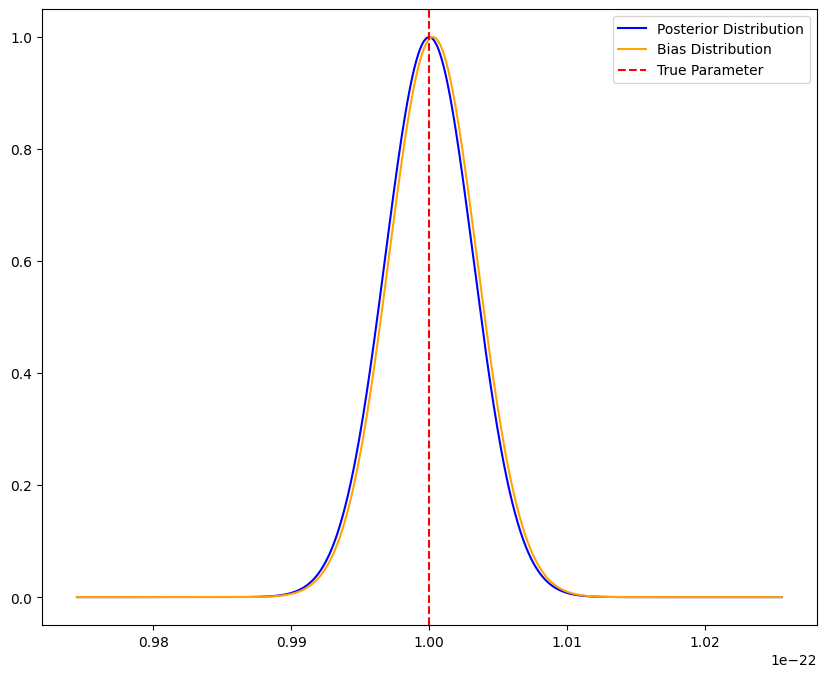

In [351]:
def Gaussian(values,mean,std):
    return np.exp(-(values - mean)**2 / (2*std**2))

# Can I try to compute the Fisher Matrix?
%load_ext autoreload
%autoreload 2
from sig_processing import fisher_matrix, CV_bias

deriv_vec, Cov_Matrix = fisher_matrix(true_params, sim_t, dt, N_t_full, psd_A)

gen_noise_f = noise_gen(seed=1234, mask=None)

# ov_Matrix_smooth_mask, deriv_vec_smooth_mask, gen_noise_f_smooth_masked, true_params, dt, N_t_full, psd_A)

bias = CV_bias(Cov_Matrix, deriv_vec, gen_noise_f, true_params, dt, N_t_full, psd_A)

truth_post = np.random.multivariate_normal(mean=true_params, cov=Cov_Matrix)

# Create smooth gaussian distribution for parameter 0
# Deal with multiple noise biases 
x_range = np.linspace(true_params[0] - 8*np.sqrt(Cov_Matrix[0,0]), 
                      true_params[0] + 8*np.sqrt(Cov_Matrix[0,0]), 1000)

mean_vals = np.array(gen_noise_f)[0]
uncertainty_param_0 = np.sqrt(Cov_Matrix[0,0])
print(uncertainty_param_0)

true_posterior = Gaussian(x_range, true_params[0], uncertainty_param_0) 
bias_posterior = Gaussian(x_range, bias[0], uncertainty_param_0) 

print(mean_vals)
fig,ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(x_range, true_posterior, label='Posterior Distribution', color='blue')
ax.plot(x_range, bias_posterior, label='Bias Distribution', color='orange')
ax.axvline(x=true_params[0], color='red', linestyle='--', label='True Parameter')
ax.legend()

In [201]:
# Check for consistency
from tqdm import tqdm as tqdm
bias_vec = []
for seed in tqdm(range(500)):
    gen_noise_f = noise_gen(seed=seed)
    bias = CV_bias(gen_noise_f, true_params, sim_t, dt, N_t_full, psd_A)
    bias_vec.append(bias[0])


    

  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq
100%|██████████| 500/500 [09:48<00:00,  1.18s/it]  


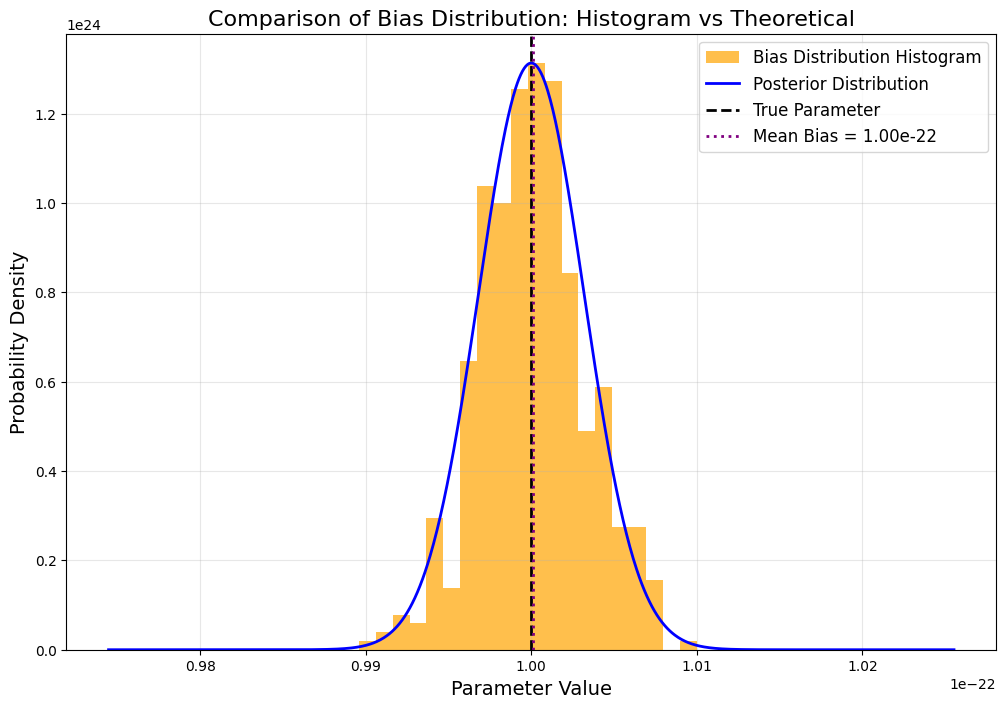

Mean of bias distribution: 1.00e-22
Standard deviation of bias distribution: 3.19e-25
Theoretical uncertainty: 3.19e-25
Ratio (empirical std / theoretical std): 1.00
Maximum bin height: 1.31e+24


In [202]:
# Create histogram of bias parameters
plt.figure(figsize=(12, 8))

# Plot histogram of bias values and get the histogram data
n, bins, patches = plt.hist(bias_vec, bins=20, density=True, alpha=0.7, color='orange', label='Bias Distribution Histogram')

# Find the maximum bin height
max_bin_height = np.max(n)

# Overlay the theoretical distributions, normalized by max bin height
plt.plot(x_range, max_bin_height * true_posterior, label='Posterior Distribution', color='blue', linewidth=2)

# Add vertical line for true parameter
plt.axvline(x=true_params[0], color='black', linestyle='--', label='True Parameter', linewidth=2)

# Add vertical line for mean of bias distribution
plt.axvline(x=np.mean(bias_vec), color='purple', linestyle=':', label=f'Mean Bias = {np.mean(bias_vec):.2e}', linewidth=2)

plt.xlabel('Parameter Value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of Bias Distribution: Histogram vs Theoretical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f"Mean of bias distribution: {np.mean(bias_vec):.2e}")
print(f"Standard deviation of bias distribution: {np.std(bias_vec):.2e}")
print(f"Theoretical uncertainty: {uncertainty_param_0:.2e}")
print(f"Ratio (empirical std / theoretical std): {np.std(bias_vec) / uncertainty_param_0:.2f}")
print(f"Maximum bin height: {max_bin_height:.2e}")

Usable data
Duty cyle is = 89.92999729754936 %


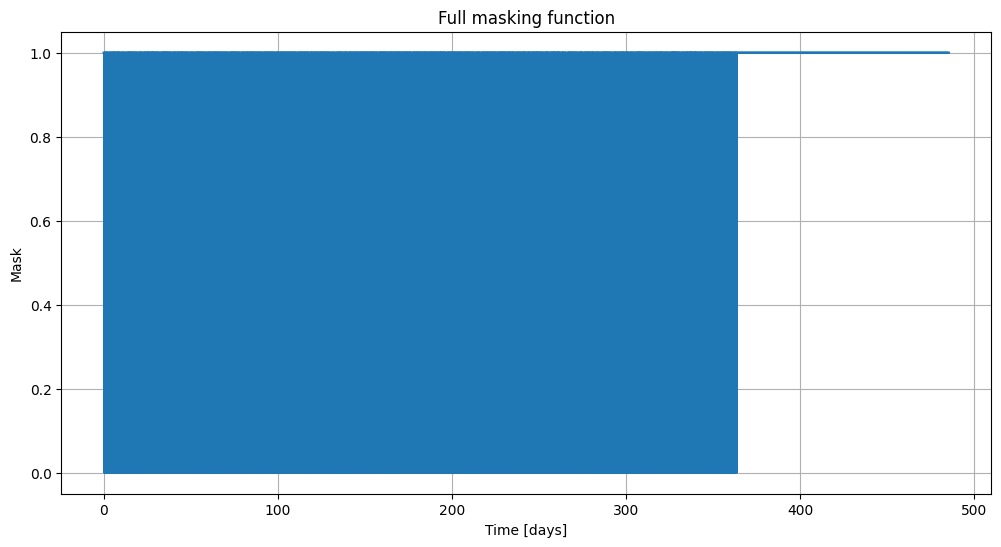

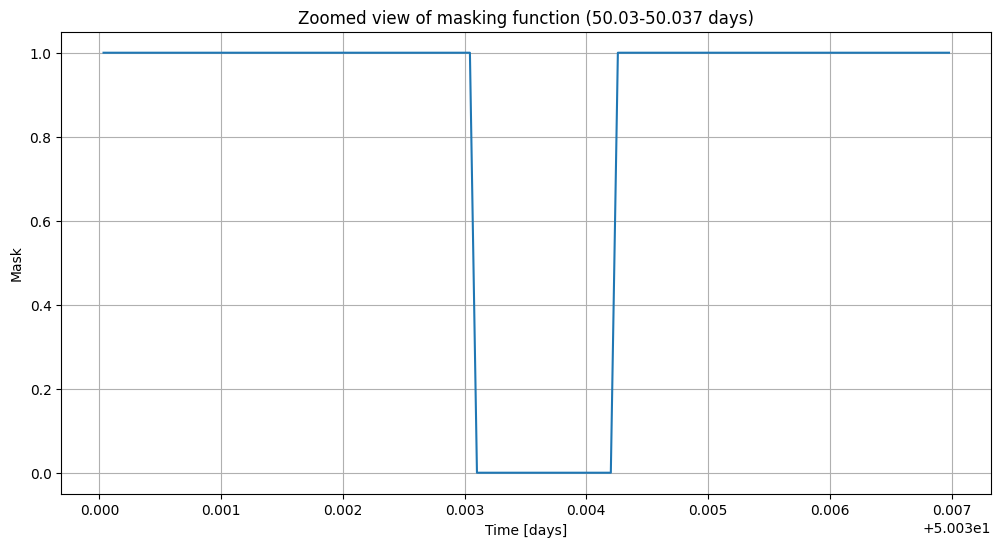

In [352]:
# Now apply a cheeky mask

from lisa_gap import GapMaskGenerator

planseed = 2618240388
unplanseed = 3387490715

# Build dictionary of gap definitions, planned and unplanned. We must 
# supply both of these, even if the rates are zero and durations are zero. 
# We can cope with arbitrary number of gaps.
gap_definitions = {
    "planned": {
        "antenna repointing": {"rate_per_year": 260, "duration_hr": 3.3}, # Fine
        "PAAM": {"rate_per_year": 1095, "duration_hr": 0.028}, # Fine
    },
    "unplanned": {
        "platform safe mode": {"rate_per_year": 3, "duration_hr": 60},
    }
}

# Initialise the class with simulation properties and whether or not to treat gaps with
# nans or not. 
gap_mask_gen = GapMaskGenerator(sim_t, 
                                dt, 
                                gap_definitions, 
                                treat_as_nan = False)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
# num_zeros = np.sum(full_mask == 0)/len(full_mask)
full_mask = gap_mask_gen.generate_mask(include_unplanned=False, include_planned=True)
full_mask_pad = np.pad(full_mask, (0, N_t_full - len(full_mask)), mode='constant', constant_values=1)
sim_t_pad = np.arange(0,N_t_full*dt, dt)
num_nans = np.sum(full_mask==0)/len(full_mask)
print("Usable data")
print(f"Duty cyle is = {100*(1-num_nans)} %")

# Plot a zoomed in view of one gap
# Plot the full time array
plt.figure(figsize=(12, 6))
plt.plot(sim_t_pad/60/60/24, full_mask_pad)
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title('Full masking function')
plt.grid()
plt.show()

# Plot a zoomed in view of one gap
plt.figure(figsize=(12, 6))
gap_start = 50.03  # days
gap_end = 50.037    # days
mask_indices = (sim_t_pad >= gap_start*24*60*60) & (sim_t_pad <= gap_end*24*60*60)
plt.plot(sim_t_pad[mask_indices]/60/60/24, full_mask_pad[mask_indices])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(f'Zoomed view of masking function ({gap_start}-{gap_end} days)')
plt.grid()
plt.show()

/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq


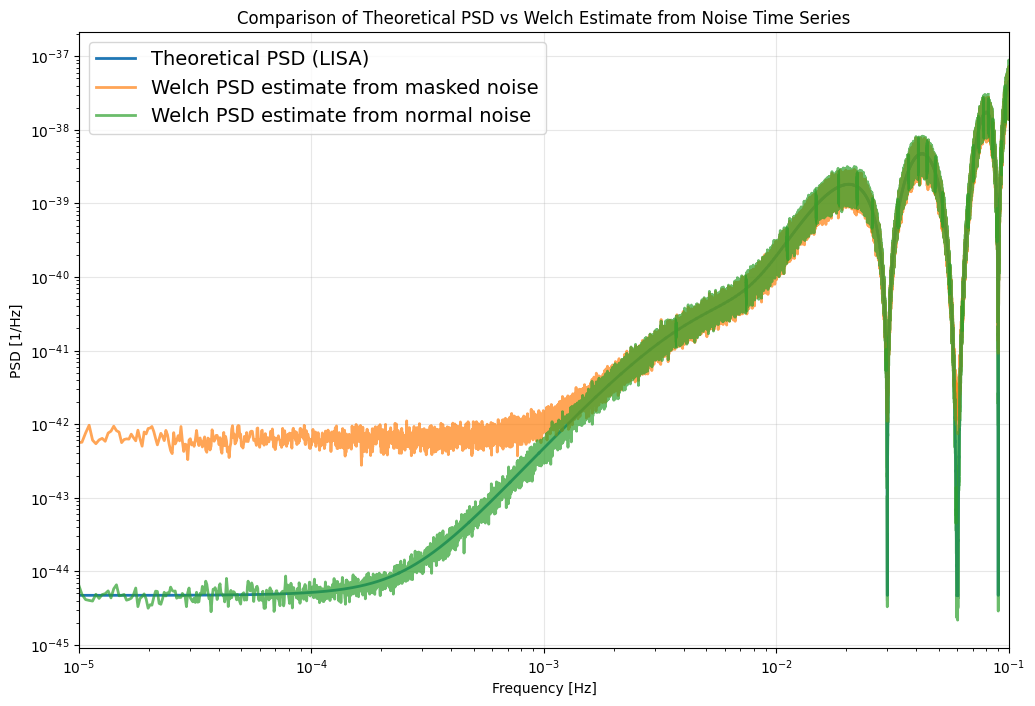

Frequency range (theoretical): 2.38e-08 - 1.00e-01 Hz
Frequency range (Welch): 3.81e-07 - 1.00e-01 Hz
Mean ratio (Welch/Theoretical) in overlap region: 1.00


In [353]:
from scipy import signal

# Compute Welch's PSD of the noise time series

noise_f_mask = noise_gen(seed = 1, mask = full_mask_pad)
# noise_f_mask_smooth = noise_gen(seed = 1, mask = smoothed_mask_pad_taper)
# noise_t_mask_smooth = np.fft.irfft(noise_f_mask_smooth)
noise_t_mask = np.fft.irfft(noise_f_mask)

freq_welch_mask, psd_welch_mask = signal.welch(noise_t_mask, fs=1/dt, nperseg=len(noise_t_mask)//16)
# freq_welch_mask_smooth, psd_welch_mask_smooth = signal.welch(noise_t_mask_smooth, fs=1/dt, nperseg=len(noise_t_mask_smooth)//16)

# Plot comparison between theoretical PSD and Welch estimate
plt.figure(figsize=(12, 8))
plt.loglog(freq, psd_A, label='Theoretical PSD (LISA)', linewidth=2)
plt.loglog(freq_welch_mask, psd_welch_mask, label='Welch PSD estimate from masked noise', alpha=0.7, linewidth=2)
# plt.loglog(freq_welch_mask_smooth, psd_welch_mask_smooth, label='Welch PSD estimate from smoothed masked noise', alpha=0.7, linewidth=2)
plt.loglog(freq_welch, psd_welch, label='Welch PSD estimate from normal noise', alpha=0.7, linewidth=2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.title('Comparison of Theoretical PSD vs Welch Estimate from Noise Time Series')
plt.xlim([1e-5, 1e-1])
plt.show()

# Print some statistics
print(f"Frequency range (theoretical): {freq[1]:.2e} - {freq[-1]:.2e} Hz")
print(f"Frequency range (Welch): {freq_welch[1]:.2e} - {freq_welch[-1]:.2e} Hz")
print(f"Mean ratio (Welch/Theoretical) in overlap region: {np.mean(psd_welch[1:]/np.interp(freq_welch[1:], freq, psd_A)):.2f}")

In [354]:
# Check for consistency
from tqdm import tqdm as tqdm
bias_mask_vec = []

deriv_vec_mask, Cov_Matrix_mask = fisher_matrix(true_params, sim_t, dt, N_t_full, psd_A, mask=full_mask)
for seed in tqdm(range(1000)):
    gen_noise_f_masked = noise_gen(seed=seed, mask=full_mask_pad)
    bias_mask = CV_bias(Cov_Matrix_mask, deriv_vec_mask, gen_noise_f_masked, true_params, dt, N_t_full, psd_A)
    bias_mask_vec.append(bias_mask)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq
100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


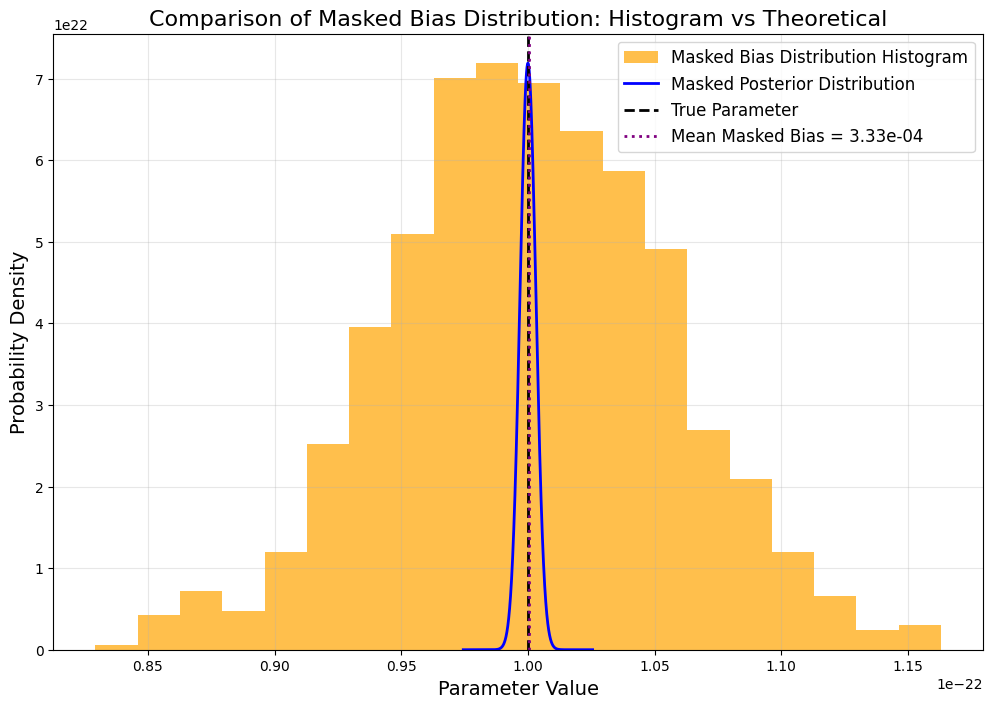

Mean of masked bias distribution: 3.33e-04
Standard deviation of masked bias distribution: 4.71e-04
Theoretical masked uncertainty: 3.14e-25
Ratio (empirical std / theoretical std): 1500452040787163348992.00
Maximum bin height: 7.19e+22


In [355]:
# Create histogram of masked bias parameters
plt.figure(figsize=(12, 8))

# Calculate uncertainty from the masked covariance matrix
uncertainty_param_0_mask = np.sqrt(Cov_Matrix_mask[0,0])

# Create smooth gaussian distribution for parameter 0 with masked uncertainty
true_posterior_mask = Gaussian(x_range, true_params[0], uncertainty_param_0_mask)

# Plot histogram of masked bias values and get the histogram data
n, bins, patches = plt.hist(np.array(bias_mask_vec)[:,0], bins=20, density=True, alpha=0.7, color='orange', label='Masked Bias Distribution Histogram')

# Find the maximum bin height
max_bin_height = np.max(n)

# Overlay the theoretical distributions, normalized by max bin height
plt.plot(x_range, max_bin_height * true_posterior_mask, label='Masked Posterior Distribution', color='blue', linewidth=2)

# Add vertical line for true parameter
plt.axvline(x=true_params[0], color='black', linestyle='--', label='True Parameter', linewidth=2)

# Add vertical line for mean of masked bias distribution
plt.axvline(x=np.mean(np.array(bias_mask_vec)[:,0]), color='purple', linestyle=':', label=f'Mean Masked Bias = {np.mean(bias_mask_vec):.2e}', linewidth=2)

plt.xlabel('Parameter Value', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Comparison of Masked Bias Distribution: Histogram vs Theoretical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print statistics
print(f"Mean of masked bias distribution: {np.mean(bias_mask_vec):.2e}")
print(f"Standard deviation of masked bias distribution: {np.std(bias_mask_vec):.2e}")
print(f"Theoretical masked uncertainty: {uncertainty_param_0_mask:.2e}")
print(f"Ratio (empirical std / theoretical std): {np.std(bias_mask_vec) / uncertainty_param_0_mask:.2f}")
print(f"Maximum bin height: {max_bin_height:.2e}")

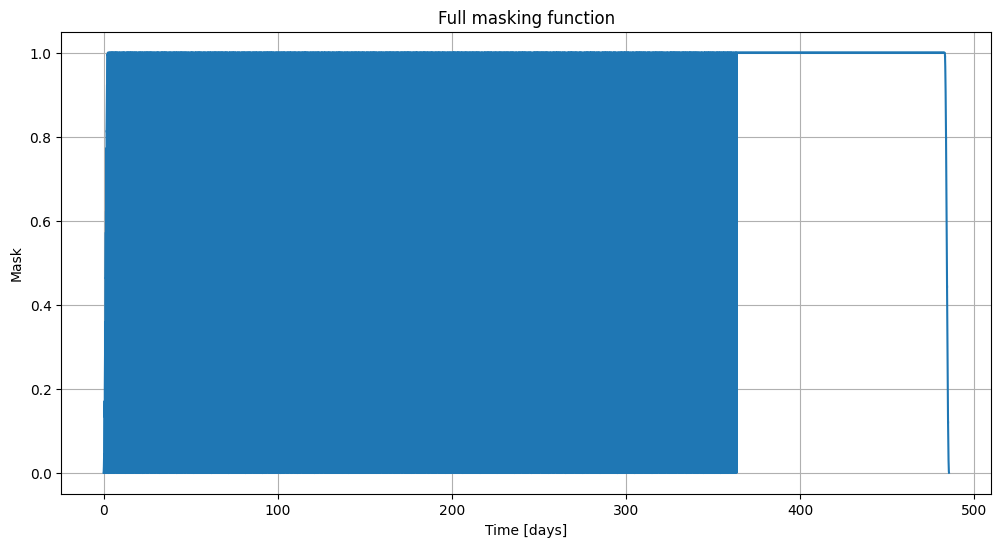

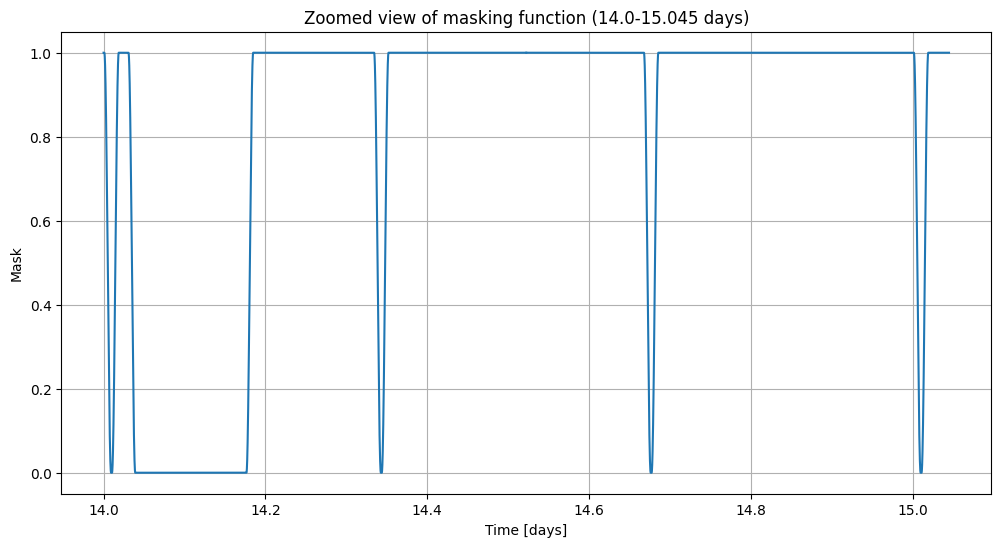

In [359]:
# Now apply a smooth taper?

taper_defs = {
    "planned": {
        "antenna repointing": {"lobe_lengths_hr": 0.2},#0.333}
        "PAAM": {"lobe_lengths_hr": 0.2},#0.333}
        # "Aliens": {"lobe_lengths_hr" : 1 * 24}},
    },
    "unplanned": {
        "platform safe mode": {"lobe_lengths_hr": 1.0}
    }
}

import scipy
smoothed_mask = gap_mask_gen.apply_smooth_taper_to_mask(full_mask, taper_gap_definitions=taper_defs)
smoothed_mask_pad = np.pad(smoothed_mask, (0, N_t_full - len(smoothed_mask)), mode='constant', constant_values=1)

# overall_tukey = scipy.signal.windows.tukey(N_t_full, alpha=0.1)

overall_tukey = scipy.signal.windows.tukey(N_t_full, alpha=0.01)

smoothed_mask_pad_taper = smoothed_mask_pad * overall_tukey

# Plot a zoomed in view of one gap
# Plot the full time array
plt.figure(figsize=(12, 6))
plt.plot(sim_t_pad/60/60/24, smoothed_mask_pad_taper)
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title('Full masking function')
plt.grid()
plt.show()

# Plot a zoomed in view of one gap
plt.figure(figsize=(12, 6))
gap_start = 14.0  # days
gap_end = 15.045    # days
mask_indices = (sim_t_pad >= gap_start*24*60*60) & (sim_t_pad <= gap_end*24*60*60)
plt.plot(sim_t_pad[mask_indices]/60/60/24, smoothed_mask_pad_taper[mask_indices])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(f'Zoomed view of masking function ({gap_start}-{gap_end} days)')
plt.grid()
plt.show()


/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq


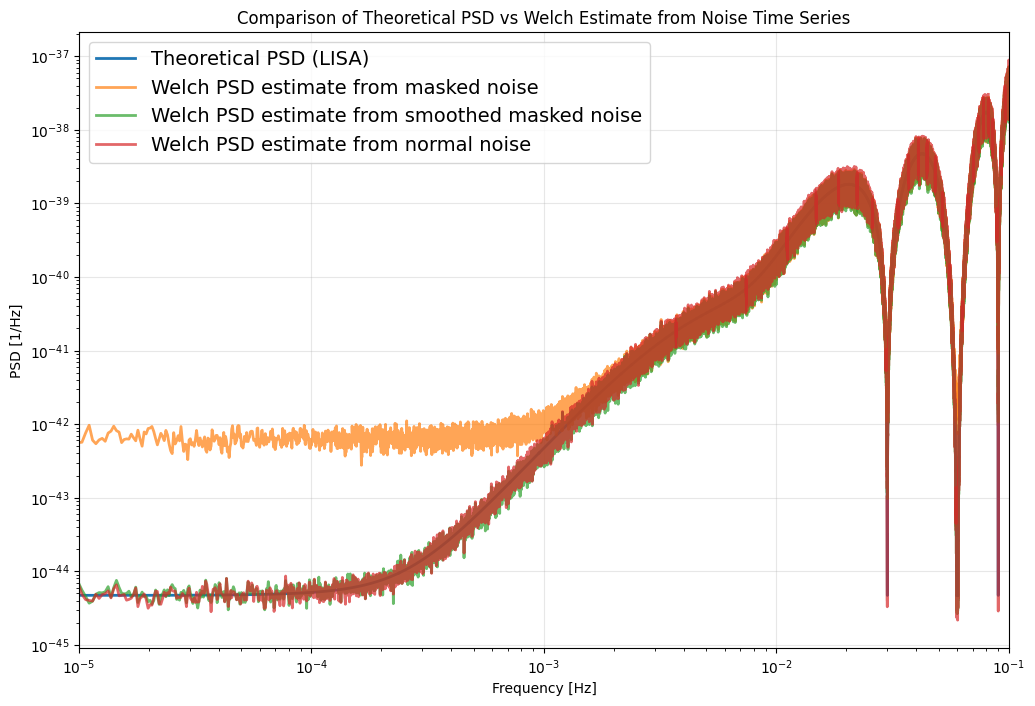

Frequency range (theoretical): 2.38e-08 - 1.00e-01 Hz
Frequency range (Welch): 3.81e-07 - 1.00e-01 Hz
Mean ratio (Welch/Theoretical) in overlap region: 1.00


In [360]:
from scipy import signal

# Compute Welch's PSD of the noise time series

noise_f_mask = noise_gen(seed = 1, mask = full_mask_pad)
noise_f_mask_smooth = noise_gen(seed = 1, mask = smoothed_mask_pad_taper)
noise_t_mask_smooth = np.fft.irfft(noise_f_mask_smooth)
noise_t_mask = np.fft.irfft(noise_f_mask)

freq_welch_mask, psd_welch_mask = signal.welch(noise_t_mask, fs=1/dt, nperseg=len(noise_t_mask)//16)
freq_welch_mask_smooth, psd_welch_mask_smooth = signal.welch(noise_t_mask_smooth, fs=1/dt, nperseg=len(noise_t_mask_smooth)//16)

# Plot comparison between theoretical PSD and Welch estimate
plt.figure(figsize=(12, 8))
plt.loglog(freq, psd_A, label='Theoretical PSD (LISA)', linewidth=2)
plt.loglog(freq_welch_mask, psd_welch_mask, label='Welch PSD estimate from masked noise', alpha=0.7, linewidth=2)
plt.loglog(freq_welch_mask_smooth, psd_welch_mask_smooth, label='Welch PSD estimate from smoothed masked noise', alpha=0.7, linewidth=2)
plt.loglog(freq_welch, psd_welch, label='Welch PSD estimate from normal noise', alpha=0.7, linewidth=2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [1/Hz]')
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.title('Comparison of Theoretical PSD vs Welch Estimate from Noise Time Series')
plt.xlim([1e-5, 1e-1])
plt.show()

# Print some statistics
print(f"Frequency range (theoretical): {freq[1]:.2e} - {freq[-1]:.2e} Hz")
print(f"Frequency range (Welch): {freq_welch[1]:.2e} - {freq_welch[-1]:.2e} Hz")
print(f"Mean ratio (Welch/Theoretical) in overlap region: {np.mean(psd_welch[1:]/np.interp(freq_welch[1:], freq, psd_A)):.2f}")

In [361]:
# Check for consistency
from tqdm import tqdm as tqdm

deriv_vec_smooth_mask, Cov_Matrix_smooth_mask = fisher_matrix(true_params, sim_t, dt, N_t_full, psd_A, mask=smoothed_mask)

bias_smooth_mask_vec = []
for seed in tqdm(range(1000)):
    gen_noise_f_smooth_masked = noise_gen(seed=seed, mask=smoothed_mask_pad_taper)
    bias_smooth_mask = CV_bias(Cov_Matrix_smooth_mask, deriv_vec_smooth_mask, gen_noise_f_smooth_masked, true_params, dt, N_t_full, psd_A)
    bias_smooth_mask_vec.append(bias_smooth_mask)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[0] = noise_f_DC
/var/folders/rl/jfjkh8kn7n3cg16ppm334z1c0000gp/T/ipykernel_31971/2729101043.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noise_f[-1] = noise_f_nyq
100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


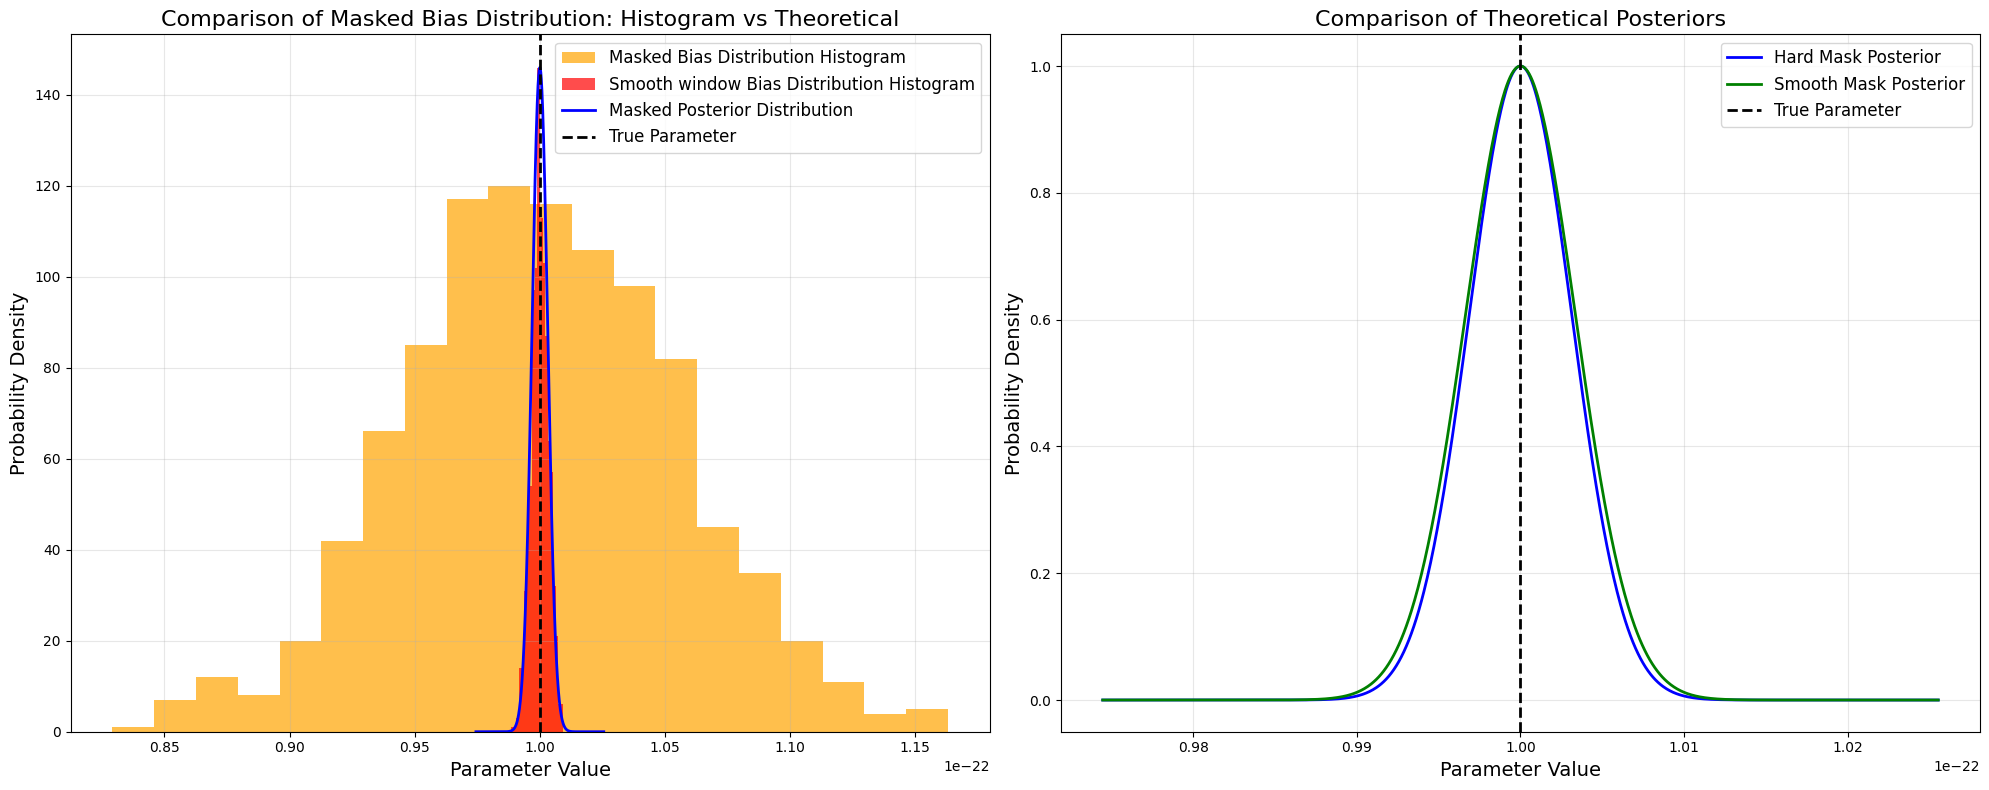

Mean of masked bias distribution: 3.33e-04
Standard deviation of masked bias distribution: 4.71e-04
Theoretical masked uncertainty: 3.14e-25
Ratio (empirical std / theoretical std): 1500452040787163348992.00
Maximum bin height: 1.46e+02


In [364]:
# Create histogram of masked bias parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot - existing histogram plot
# Calculate uncertainty from the masked covariance matrix
uncertainty_param_0_mask = np.sqrt(Cov_Matrix_mask[0,0])
uncertainty_param_0_smooth_mask = np.sqrt(Cov_Matrix_smooth_mask[0,0])

# Create smooth gaussian distribution for parameter 0 with masked uncertainty
true_posterior_mask = Gaussian(x_range, true_params[0], uncertainty_param_0_mask)
true_posterior_smooth_mask = Gaussian(x_range, true_params[0], uncertainty_param_0_smooth_mask)

# Plot histogram of masked bias values and get the histogram data
n, bins, patches = ax1.hist(np.array(bias_mask_vec)[:,0], bins=20, density=False, alpha=0.7, color='orange', label='Masked Bias Distribution Histogram')
n, bins, patches = ax1.hist(np.array(bias_smooth_mask_vec)[:,0], bins=20, density=False, alpha=0.7, color='red', label='Smooth window Bias Distribution Histogram')

# Find the maximum bin height
max_bin_height = np.max(n)

# Overlay the theoretical distributions, normalized by max bin height
ax1.plot(x_range, max_bin_height * true_posterior_mask, label='Masked Posterior Distribution', color='blue', linewidth=2)

# Add vertical line for true parameter
ax1.axvline(x=true_params[0], color='black', linestyle='--', label='True Parameter', linewidth=2)

ax1.set_xlabel('Parameter Value', fontsize=14)
ax1.set_ylabel('Probability Density', fontsize=14)
ax1.set_title('Comparison of Masked Bias Distribution: Histogram vs Theoretical', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Right plot - comparison of theoretical posteriors
ax2.plot(x_range, true_posterior_mask, label='Hard Mask Posterior', color='blue', linewidth=2)
ax2.plot(x_range, true_posterior_smooth_mask, label='Smooth Mask Posterior', color='green', linewidth=2)
ax2.axvline(x=true_params[0], color='black', linestyle='--', label='True Parameter', linewidth=2)

ax2.set_xlabel('Parameter Value', fontsize=14)
ax2.set_ylabel('Probability Density', fontsize=14)
ax2.set_title('Comparison of Theoretical Posteriors', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Mean of masked bias distribution: {np.mean(bias_mask_vec):.2e}")
print(f"Standard deviation of masked bias distribution: {np.std(bias_mask_vec):.2e}")
print(f"Theoretical masked uncertainty: {uncertainty_param_0_mask:.2e}")
print(f"Ratio (empirical std / theoretical std): {np.std(bias_mask_vec) / uncertainty_param_0_mask:.2f}")
print(f"Maximum bin height: {max_bin_height:.2e}")

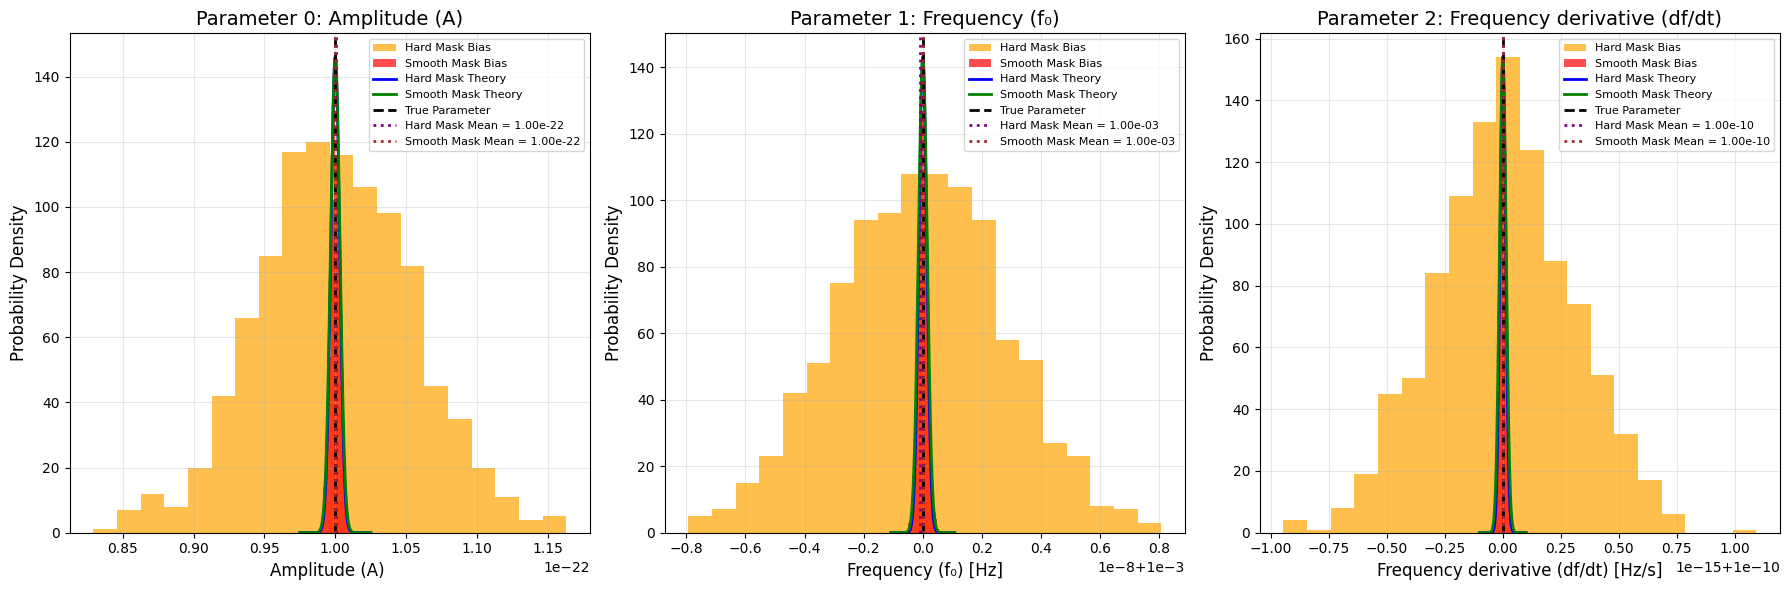

In [363]:
# Create comparison plots for all three parameters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Parameter names for labels
param_names = ['Amplitude (A)', 'Frequency (f₀)', 'Frequency derivative (df/dt)']
param_units = ['', '[Hz]', '[Hz/s]']

for i in range(3):
    # Calculate uncertainties for both masked and smooth masked cases
    uncertainty_param_mask = np.sqrt(Cov_Matrix_mask[i,i])
    uncertainty_param_smooth_mask = np.sqrt(Cov_Matrix_smooth_mask[i,i])
    
    # Create parameter range for this parameter
    param_range = np.linspace(true_params[i] - 8*uncertainty_param_mask, 
                              true_params[i] + 8*uncertainty_param_mask, 1000)
    
    # Create theoretical distributions
    true_posterior_mask = Gaussian(param_range, true_params[i], uncertainty_param_mask)
    true_posterior_smooth_mask = Gaussian(param_range, true_params[i], uncertainty_param_smooth_mask)
    
    # Extract parameter values from bias vectors
    bias_mask_param = [bias[i] for bias in bias_mask_vec]
    bias_smooth_mask_param = [bias[i] for bias in bias_smooth_mask_vec]
    
    # Plot histograms
    n1, bins1, patches1 = axes[i].hist(bias_mask_param, bins=20, density=False, alpha=0.7, 
                                       color='orange', label='Hard Mask Bias')
    n2, bins2, patches2 = axes[i].hist(bias_smooth_mask_param, bins=20, density=False, alpha=0.7, 
                                       color='red', label='Smooth Mask Bias')
    
    # Find maximum bin height for normalization
    max_bin_height = max(np.max(n1), np.max(n2))
    
    # Overlay theoretical distributions
    axes[i].plot(param_range, max_bin_height * true_posterior_mask, 
                 label='Hard Mask Theory', color='blue', linewidth=2)
    axes[i].plot(param_range, max_bin_height * true_posterior_smooth_mask, 
                 label='Smooth Mask Theory', color='green', linewidth=2)
    
    # Add vertical line for true parameter
    axes[i].axvline(x=true_params[i], color='black', linestyle='--', 
                    label='True Parameter', linewidth=2)
    
    # Add vertical lines for mean bias
    axes[i].axvline(x=np.mean(bias_mask_param), color='purple', linestyle=':', 
                    label=f'Hard Mask Mean = {np.mean(bias_mask_param):.2e}', linewidth=2)
    axes[i].axvline(x=np.mean(bias_smooth_mask_param), color='brown', linestyle=':', 
                    label=f'Smooth Mask Mean = {np.mean(bias_smooth_mask_param):.2e}', linewidth=2)
    
    # Formatting
    axes[i].set_xlabel(f'{param_names[i]} {param_units[i]}', fontsize=12)
    axes[i].set_ylabel('Probability Density', fontsize=12)
    axes[i].set_title(f'Parameter {i}: {param_names[i]}', fontsize=14)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()